In [1]:
import jax.numpy as jnp
import numpy as onp

import matplotlib.pyplot as plt
import matplotlib as mpl

from calcgp import FullFunction, FullGradient, FullIntegral
from calcgp.kernels import RBF

In [2]:
data = onp.loadtxt("H2O-eos-2020-11-23.dat")
data = jnp.array(data)

In [3]:
rho = data[:,0]
T = data[:,1]
p = data[:,2]
u = data[:,3]

In [4]:
def transform(x):
    lb = jnp.min(x)
    ub = jnp.max(x)

    return (x - lb) / (ub - lb), lb, ub

def inverse(x, lb, ub):
    return lb + (ub - lb) * x

## Plot initial data

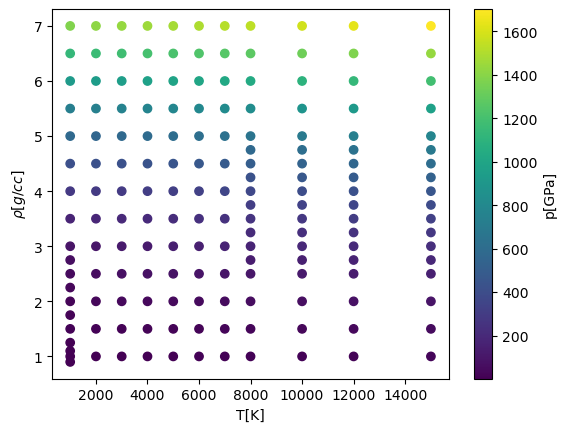

In [5]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=onp.min(p), vmax=onp.max(p))

fig, ax = plt.subplots(1,1)

ax.scatter(T, rho, c=p, cmap=cmap, norm=norm)
ax.set_xlabel("T[K]")
ax.set_ylabel("$\\rho [g/cc]$")

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("p[GPa]")

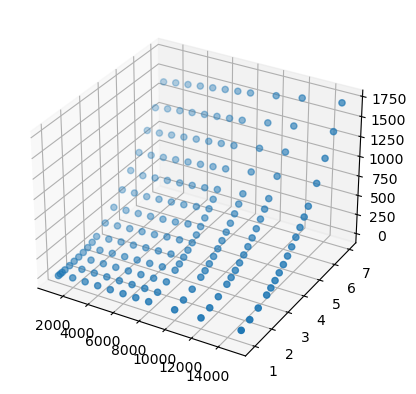

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(T, rho, p)

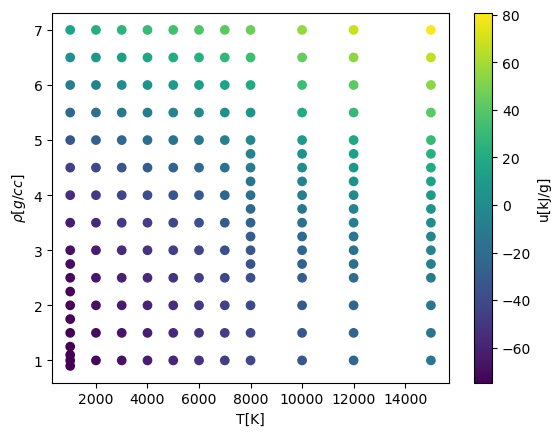

In [7]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=onp.min(u), vmax=onp.max(u))

fig, ax = plt.subplots(1,1)

ax.scatter(T, rho, c=u, cmap=cmap, norm=norm)
ax.set_xlabel("T[K]")
ax.set_ylabel("$\\rho[g/cc]$")

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("u[kJ/g]")

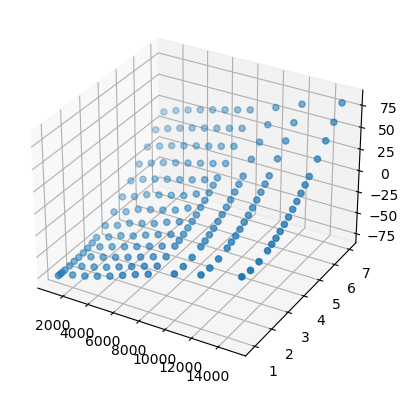

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(T, rho, u)

## Predict $p$

### Map all data to $[0,1]$

In [9]:
norm_T, lb_T, ub_T = transform(T)
norm_rho, lb_rho, ub_rho = transform(rho)
norm_p, lb_p, ub_p = transform(p)

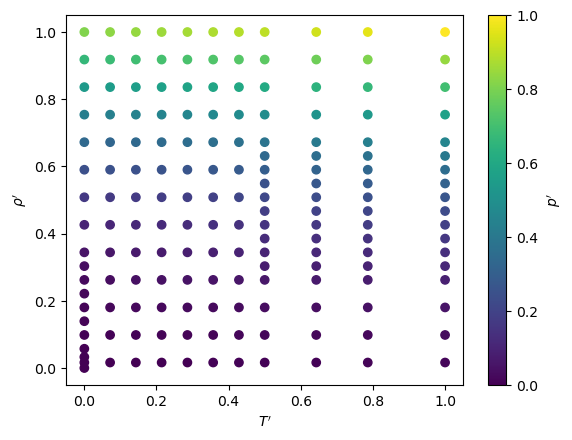

In [10]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(1,1)

ax.scatter(norm_T, norm_rho, c=norm_p, cmap=cmap, norm=norm)
ax.set_xlabel("$T'$")
ax.set_ylabel("$\\rho'$")

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("$p'$")

In [11]:
X = jnp.vstack((norm_T, norm_rho)).T
Y = norm_p

In [12]:
kernel = RBF(3)
model = FullFunction(kernel, noise=1e-2)

In [13]:
model.train(X, Y)

True


In [14]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(0,1, 101), jnp.linspace(0,1, 101))).T.reshape(101**2, 2)

mean, std = model.predict(predict_grid)

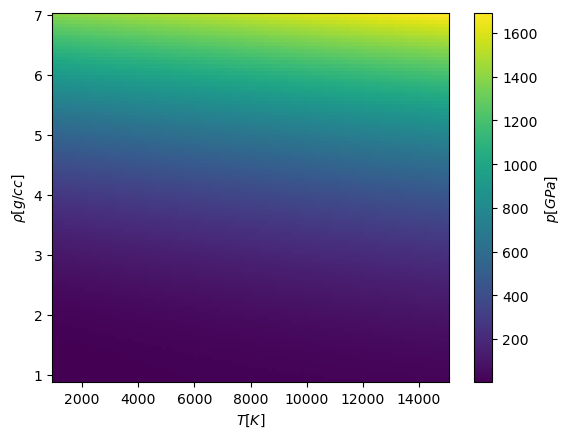

In [15]:
mean = mean.reshape(101,101)
std = std.reshape(101,101)

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, inverse(mean.T, lb_p, ub_p))
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$p[GPa]$")

In [16]:
Y_pred, Y_err = model.predict(X)

print(jnp.mean(jnp.square(Y-Y_pred)))

1.1283739e-05


## Predict $u$

In [17]:
norm_T, lb_T, ub_T = transform(T)
norm_rho, lb_rho, ub_rho = transform(rho)
norm_u, lb_u, ub_u = transform(u)

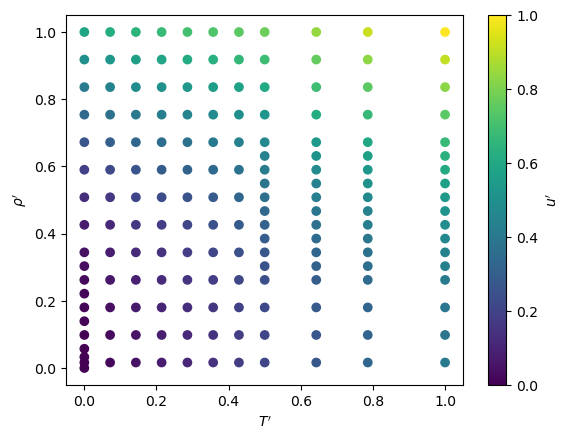

In [18]:
cmap = mpl.colormaps['viridis']
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig, ax = plt.subplots(1,1)

ax.scatter(norm_T, norm_rho, c=norm_u, cmap=cmap, norm=norm)
ax.set_xlabel("$T'$")
ax.set_ylabel("$\\rho'$")

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
cbar.set_label("$u'$")

In [19]:
X = jnp.vstack((norm_T, norm_rho)).T
Y = norm_u

In [20]:
kernel = RBF()
model = FullFunction(kernel, noise=1e-2)

In [21]:
model.train(X, Y)

True


In [22]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(0,1, 101), jnp.linspace(0,1, 101))).T.reshape(101**2, 2)

mean, std = model.predict(predict_grid)

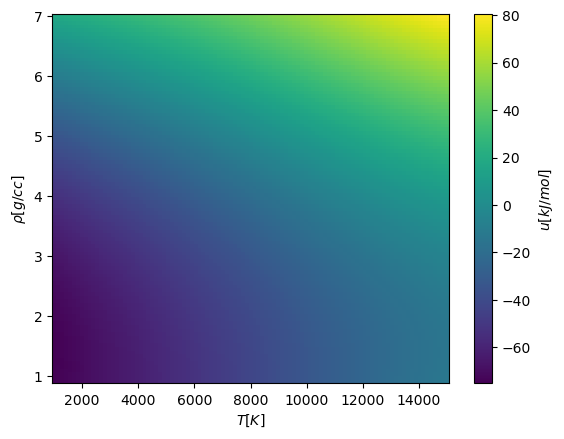

In [23]:
mean = mean.reshape(101,101)
std = std.reshape(101,101)

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, inverse(mean.T, lb_u, ub_u))
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$u[kJ/mol]$")

In [24]:
Y_pred, Y_err = model.predict(X)

print(jnp.mean(jnp.square(Y-Y_pred)))

2.3937482e-05


## Predict $\nabla p$

In [25]:
norm_T, lb_T, ub_T = transform(T)
norm_rho, lb_rho, ub_rho = transform(rho)
norm_p, lb_p, ub_p = transform(p)

In [26]:
X = jnp.vstack((norm_T, norm_rho)).T
Y = norm_p

In [27]:
kernel = RBF()
model = FullGradient(kernel, noise=1e-2)

In [28]:
model.train(X, Y)

True


/home/lukas/miniconda3/envs/gpr/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [29]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(0,1, 101), jnp.linspace(0,1, 101))).T.reshape(101**2, 2)

mean, std = model.predict(predict_grid)

In [30]:
# mean = mean.reshape(101**2, 2)
# std = std.reshape(101**2, 2)

dpdT = mean[:,0]
dpdrho = mean[:,1]
dpdT_err = std[:,0]
dpdrho_err = std[:,1]

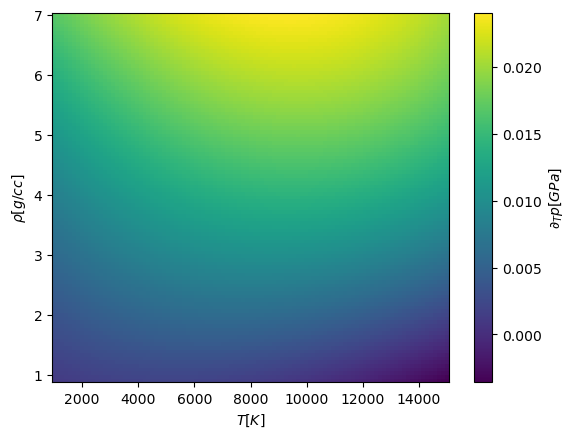

In [31]:
dpdT = dpdT.reshape(101,101)

dpdT = ((ub_p - lb_p) / (ub_T - lb_T)) * dpdT

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dpdT.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$\partial_{T}p[GPa]$")

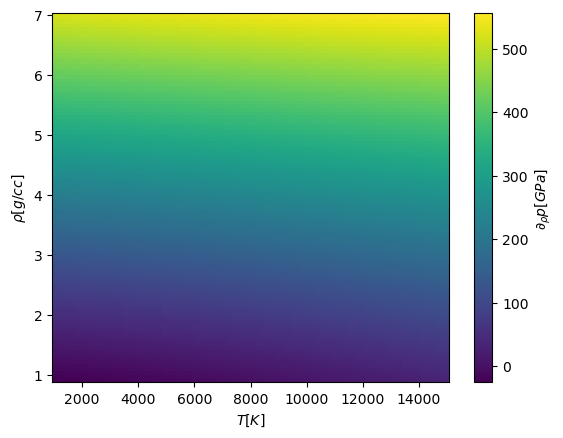

In [32]:
dpdrho = dpdrho.reshape(101,101)

dpdrho = ((ub_p - lb_p) / (ub_rho - lb_rho)) * dpdrho

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dpdrho.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$\partial_{\\rho}p[GPa]$")

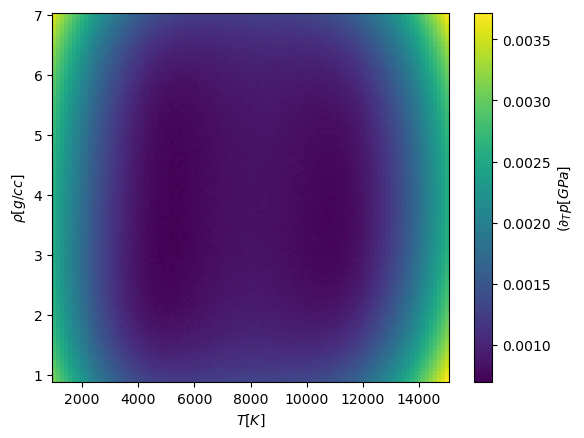

In [33]:
dpdT_err = dpdT_err.reshape(101,101)

dpdT_err = ((ub_p - lb_p) / (ub_T - lb_T)) * dpdT_err

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dpdT_err.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$(\partial_{T}p[GPa]$")

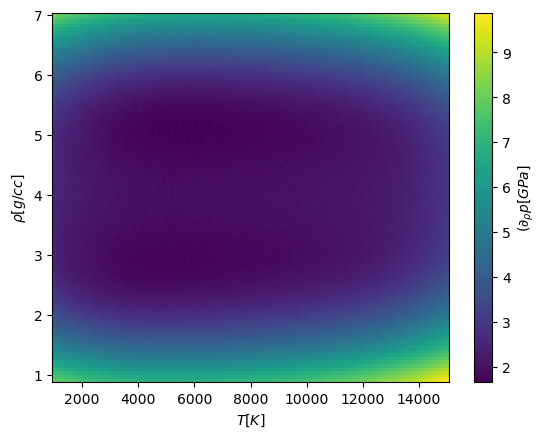

In [34]:
dpdrho_err = dpdrho_err.reshape(101,101)

dpdrho_err = ((ub_p - lb_p) / (ub_rho - lb_rho)) * dpdrho_err

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dpdrho_err.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$(\partial_{\\rho}p[GPa]$")

## Predict $\nabla u$

In [35]:
norm_T, lb_T, ub_T = transform(T)
norm_rho, lb_rho, ub_rho = transform(rho)
norm_u, lb_u, ub_u = transform(u)

In [36]:
X = jnp.vstack((norm_T, norm_rho)).T
Y = norm_u

In [37]:
kernel = RBF()
model = FullGradient(kernel, noise=1e-2)

In [38]:
model.train(X, Y)

True


In [39]:
predict_grid = jnp.array(jnp.meshgrid(jnp.linspace(0,1, 101), jnp.linspace(0,1, 101))).T.reshape(101**2, 2)

mean, std = model.predict(predict_grid)

In [41]:
# mean = mean.reshape(101**2, 2)
# std = std.reshape(101**2, 2)

dudT = mean[:,0]
dudrho = mean[:,1]
dudT_err = std[:,0]
dudrho_err = std[:,1]

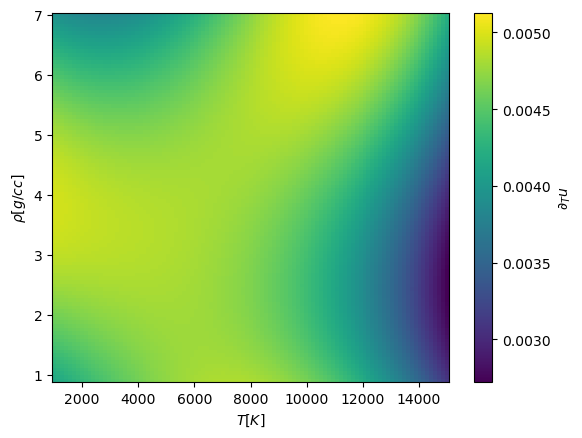

In [42]:
dudT = dudT.reshape(101,101)

dudT = ((ub_u - lb_u) / (ub_T - lb_T)) * dudT

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dudT.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$\partial_{T}u$")

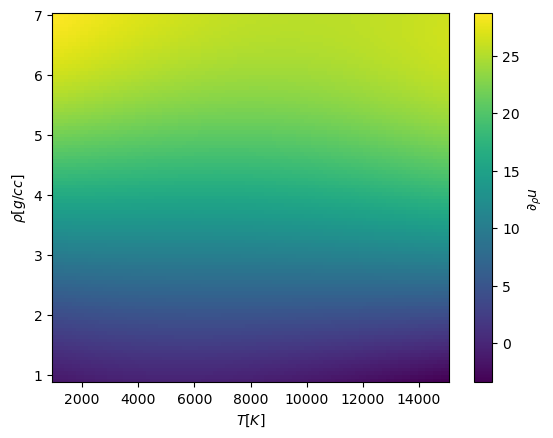

In [43]:
dudrho = dudrho.reshape(101,101)

dudrho = ((ub_u - lb_u) / (ub_rho - lb_rho)) * dudrho

mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(*mesh, dudrho.T)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel("$T[K]$")
ax.set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$\partial_{\\rho}u$")

## Material Properties

### Specific heat

$$c_v = \bigg(\frac{\partial u}{\partial T}\bigg)_{\rho}$$

$$c_p = c_v + \frac{T \big(\frac{\partial p}{\partial T}\big)^2}{\rho^2 \big(\frac{\partial p}{\partial \rho}\big)}$$

Bei Normalbedingungen hat Wasser ein $C_V$ von $4190 J\cdot kg \cdot K$. Hier hat $u$ Einheit $kJ/g$. Also das $c_V$ von Wasser ist dann $4.19 J \cdot K = 0.00419 kJ\cdot K$.

In [52]:
c_v = dudT.T
cv_err = dudT_err.reshape(101,101).T

cv_err = ((ub_u - lb_u) / (ub_T - lb_T)) * cv_err

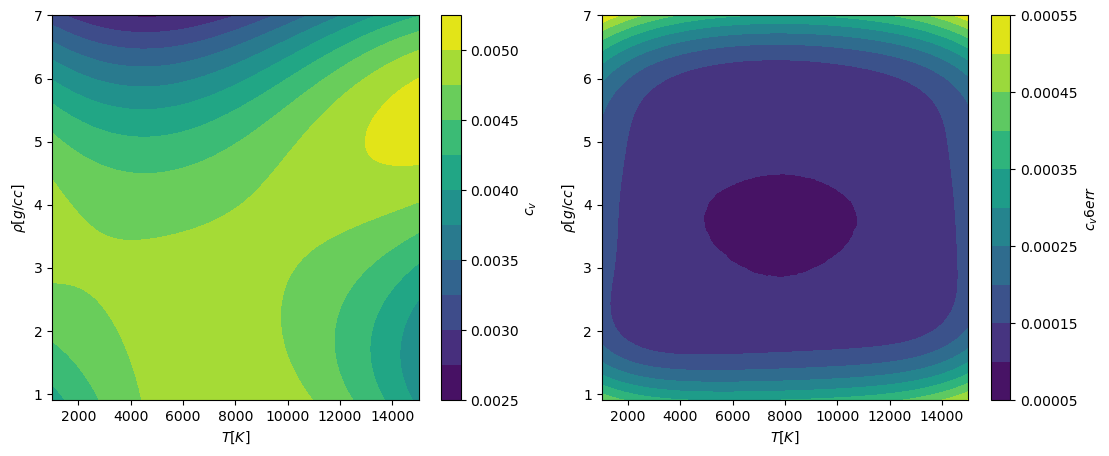

In [63]:
mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

fig, ax = plt.subplots(1,2, figsize=(13,5))
im = ax[0].contourf(*mesh, c_v, 10)
cbar = fig.colorbar(im, ax=ax[0])
ax[0].set_xlabel("$T[K]$")
ax[0].set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$c_v$")

im = ax[1].contourf(*mesh, cv_err, 10)
cbar = fig.colorbar(im, ax=ax[1])
ax[1].set_xlabel("$T[K]$")
ax[1].set_ylabel("$\\rho [g/cc]$")

cbar.set_label("$c_v6{err}$")

In [79]:
# T_mesh, rho_mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

# c_p = c_v + (T_mesh * dpdT**2) / (rho_mesh**2 * dpdrho)

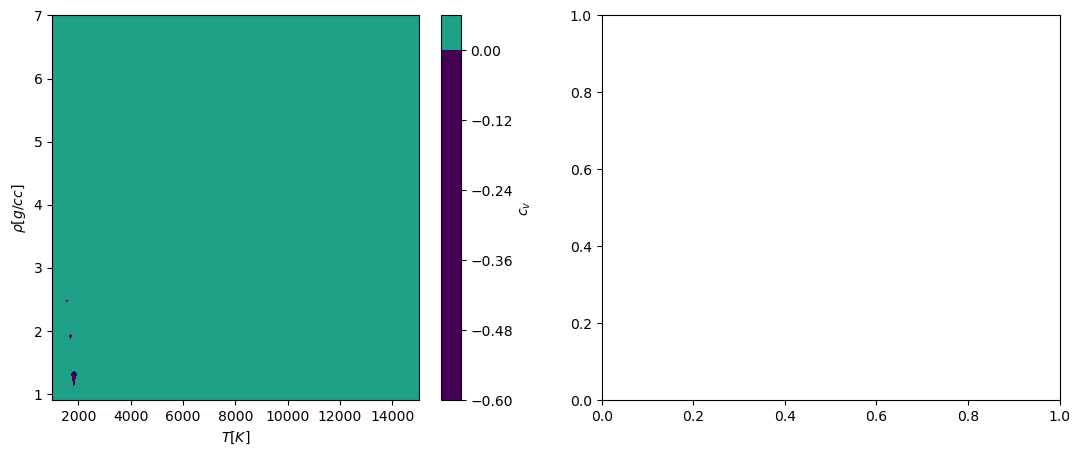

In [91]:
# mesh = jnp.meshgrid(jnp.linspace(lb_T, ub_T, 101),jnp.linspace(lb_rho, ub_rho, 101))

# fig, ax = plt.subplots(1,2, figsize=(13,5))
# im = ax[0].contourf(*mesh, c_p, 10, vmin=-0.01)
# cbar = fig.colorbar(im, ax=ax[0])
# ax[0].set_xlabel("$T[K]$")
# ax[0].set_ylabel("$\\rho [g/cc]$")

# cbar.set_label("$c_v$")

# # im = ax[1].contourf(*mesh, cv_err, 10)
# # cbar = fig.colorbar(im, ax=ax[1])
# # ax[1].set_xlabel("$T[K]$")
# # ax[1].set_ylabel("$\\rho [g/cc]$")

# # cbar.set_label("$c_v6{err}$")